In [ ]:
import numpy as np
import pandas as pd
from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import plot_precision_recall_curve
from scipy import stats


In [ ]:
data = pd.read_csv('srcdata.csv')

In [ ]:
dataClean = data.iloc[:, 1:]
dataClean['StringOffset'] = dataClean['StringOffset'].astype(int)
#dataClean = dataClean.drop_duplicates(keep='first')
dataClean = dataClean.replace([np.inf, -np.inf], 0)

dataClean.drop(dataClean.index[(dataClean["BroadcastReceiverOccurenceFrequency"] == 3) & 
                       (dataClean["ActivityOccurenceFrequency:"] == 29) & 
                       (dataClean["ServicesOccurenceFrequency:"] == 30) & 
                       (dataClean["TotalComponentFrequency: "] == 62) & 
                       (dataClean["MostCommonTargetComponent: "] == 26) & 
                       (dataClean["MostCommonSourceComponent: "] == 8) & 
                       (dataClean["InternalOccurence:"] == 4) & 
                       (dataClean["ExternalOccurence"] == 58)], inplace=True) # The outlier of 1500 pairs.


dataClean.shape

(8441, 21)

In [ ]:
X = dataClean.iloc[:,:-1]
X = dataClean[["BroadcastReceiverOccurenceFrequency","ActivityOccurenceFrequency:","ServicesOccurenceFrequency:","TotalComponentFrequency: ",
          "MostCommonTargetComponent: ","MostCommonSourceComponent: ","InternalOccurence:","ExternalOccurence",
          "Permissions","NormalPerms","DangerousPerms","SignaturePerms","RiskRatePerPerms",
          "androidApiCount","javaApiCount","totalApiCount","apiPerComponent",
          "userActionCount","userActionPerComponent","StringOffset"]]
X['StringOffset'] = X['StringOffset'].astype(int)
y = dataClean['Repacked'].astype(int)
print(y.value_counts()) #75.2% for OG set
print(X['StringOffset'].value_counts()) #67.4% for OG set

# divide = [y for x, y in data.groupby('Repacked', as_index=False)]
# RP = divide[1]
# NotRP = divide[0]
# CutRP = RP.iloc[:-1000,]
# Z = pd.concat([CutRP, NotRP])
# print(Z.shape)

# X = Z.iloc[:, 1:-1]
# X['StringOffset'] = X['StringOffset'].astype(int)
# y = Z['Repacked'].astype(int)


1    6081
0    2360
Name: Repacked, dtype: int64
0    5342
1    3099
Name: StringOffset, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
#Import the SMOTE-NC
#from imblearn.over_sampling import SMOTENC
#Create the oversampler. For SMOTE-NC we need to pinpoint the column position where is the categorical features are. In this case, 
#'IsActiveMember' is positioned in the second column we input [1] as the parameter. If you have more than one categorical columns, 
#just input all the columns position
#smotenc = SMOTENC([1],random_state = 101)
#X_oversample, y_oversample = smotenc.fit_resample(X_train, y_train) example for the last two lines

X = X.replace([np.inf, -np.inf], 0)
#X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

smotenc = SMOTENC([19],random_state = 101)
X_train, y_train = smotenc.fit_resample(X_train, y_train)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=40, weights='uniform')
knn.fit(X_train, y_train)
knnpredictions = knn.predict(X_test)
accuracy = (metrics.accuracy_score(y_test, knnpredictions))
print(f"knn accuracy: {accuracy}")
precision = precision_score(y_test, knnpredictions, average='binary')
recall = recall_score(y_test, knnpredictions, average='binary')
score = f1_score(y_test, knnpredictions, average='binary')
print(f"Precision: {precision} Recall: {recall} F1-Score: {score}")
precision, recall, _ = precision_recall_curve(y_test, knnpredictions)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

#RESULTS with different SMOTE strategy:
#knn accuracy: 0.6252692031586504
#Precision: 0.8236074270557029 Recall: 0.6148514851485148 F1-Score: 0.7040816326530611
#PR AUC: 0.859

knn accuracy: 0.7146240378922439
Precision: 0.7447229551451188 Recall: 0.9223856209150327 F1-Score: 0.8240875912408759
PR AUC: 0.862


In [ ]:
model = svm.SVC()
model.fit(X_train,y_train)
svmpredictions = model.predict(X_test)
acc = metrics.accuracy_score(y_test, svmpredictions)
print(f"SVM accuracy: {acc}")
precision = precision_score(y_test, svmpredictions, average='binary')
recall = recall_score(y_test, svmpredictions, average='binary')
score = f1_score(y_test, svmpredictions, average='binary')
print(f"Precision: {precision} Recall: {recall} F1-Score: {score}")
precision, recall, _ = precision_recall_curve(y_test, svmpredictions)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

SVM accuracy: 0.7211367673179396
Precision: 0.7288753799392097 Recall: 0.9795751633986928 F1-Score: 0.835831300104566
PR AUC: 0.862


In [ ]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
print(f"GNB Accuracy: {gnb.score(X_test, y_test)}")
precision = precision_score(y_test, gnb.predict(X_test), average='binary')
recall = recall_score(y_test, gnb.predict(X_test), average='binary')
score = f1_score(y_test, gnb.predict(X_test), average='binary')
print(f"Precision: {precision} Recall: {recall} F1-Score: {score}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

Number of mislabeled points out of a total 1689 points : 485
GNB Accuracy: 0.7128478389579633
Precision: 0.7310819262038775 Recall: 0.9550653594771242 F1-Score: 0.828196953595466
PR AUC: 0.859


In [ ]:
deetree = tree.DecisionTreeClassifier()
deetree.fit(X_train, y_train)
deetreeprediction = deetree.predict(X_test)
print(f"Decision Tree Acc: {deetree.score(X_test, y_test)}")
precision = precision_score(y_test, deetreeprediction, average='binary')
recall = recall_score(y_test, deetreeprediction, average='binary')
score = f1_score(y_test, deetreeprediction, average='binary')
print(f"Precision: {precision} Recall: {recall} F1-Score: {score}")
precision, recall, _ = precision_recall_curve(y_test, deetreeprediction)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

Decision Tree Acc: 0.6950858496151568
Precision: 0.774593338497289 Recall: 0.8169934640522876 F1-Score: 0.7952286282306164
PR AUC: 0.862


In [ ]:
lrg = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
lrgprediction = lrg.predict(X_test)
print(f"Logistic Regression Accuracy: {lrg.score(X_test, y_test)}")
precision = precision_score(y_test, lrgprediction, average='binary')
recall = recall_score(y_test, lrgprediction, average='binary')
score = f1_score(y_test, lrgprediction, average='binary')
print(f"Precision: {precision} Recall: {recall} F1-Score: {score}")
precision, recall, _ = precision_recall_curve(y_test, lrgprediction)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

Logistic Regression Accuracy: 0.7229129662522202
Precision: 0.7260765550239234 Recall: 0.9918300653594772 F1-Score: 0.8383977900552486
PR AUC: 0.862


In [ ]:
rfc = RandomForestClassifier(max_depth=5, random_state=0)
rfc.fit(X_train, y_train)
rfcpredictions = rfc.predict(X_test)
print(f"RFC Accuracy: {rfc.score(X_test, y_test)}")
precision = precision_score(y_test, rfcpredictions, average='binary')
recall = recall_score(y_test, rfcpredictions, average='binary')
score = f1_score(y_test, rfcpredictions, average='binary')
print(f"Precision: {precision} Recall: {recall} F1-Score: {score}")
precision, recall, _ = precision_recall_curve(y_test, rfcpredictions)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

RFC Accuracy: 0.7270574304322084
Precision: 0.726678550207962 Recall: 0.9991830065359477 F1-Score: 0.8414172686618507
PR AUC: 0.863


In [ ]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(activation='logistic', solver='sgd', hidden_layer_sizes=(10,15), random_state=1)
nn.fit(X_train, y_train)
nnpred = nn.predict(X_test)

a=y_test.values
count=0
for i in range(len(nnpred)):
    if nnpred[i]==a[i]:
        count=count+1

lengthofpred = len(nnpred)
nnresults = count/lengthofpred

print(f"Neural Network Accuracy: {nnresults}")
precision = precision_score(y_test, nnpred, average='binary')
recall = recall_score(y_test, nnpred, average='binary')
score = f1_score(y_test, nnpred, average='binary')
print(f"Precision: {precision} Recall: {recall} F1-Score: {score}")
precision, recall, _ = precision_recall_curve(y_test, nnpred)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

Neural Network Accuracy: 0.7246891651865008
Precision: 0.7246891651865008 Recall: 1.0 F1-Score: 0.8403707518022657
PR AUC: 0.862


In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {
    'max_depth': 100,  # the maximum depth of each tree
    'eta': 1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'binary:hinge',
    'num_class': 1}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)
xgbpreds = bst.predict(dtest)

print(f"XGB Accuracy: {xgbpreds}")
precision = precision_score(y_test, xgbpreds, average='binary')
recall = recall_score(y_test, xgbpreds, average='binary')
score = f1_score(y_test, xgbpreds, average='binary')
print(f"Precision: {precision} Recall: {recall} F1-Score: {score}")
precision, recall, _ = precision_recall_curve(y_test, xgbpreds)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

XGB Accuracy: [1. 1. 1. ... 0. 1. 1.]
Precision: 0.7781109445277361 Recall: 0.8480392156862745 F1-Score: 0.8115715402658328
PR AUC: 0.868


In [ ]:

#I should use PrecisionRecallDisplay
#precision, recall, thresholds = precision_recall_curve(y_test, knnpredictions)
#display = PrecisionRecallDisplay.from_estimator(knn, X_test, y_test, name="KNN")
#_ = display.ax_.set_title("2-class Precision-Recall curve")

#precision, recall, thresholds = precision_recall_curve(y_test, svmpredictions)
#display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="SVM")
#_ = display.ax_.set_title("2-class Precision-Recall curve")

#display = PrecisionRecallDisplay.from_estimator(rfc, X_test, y_test, name="RFC")
#_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
count = 1
av = []
numcols = len(data.columns)
while(count < numcols):
   curr = data.iloc[:,count-1:count].mean(skipna = False)
   av.append(curr)
   count = count + 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


False    4710
True     2454
Name: StringOffset, dtype: int64
False    1715
True      645
Name: StringOffset, dtype: int64


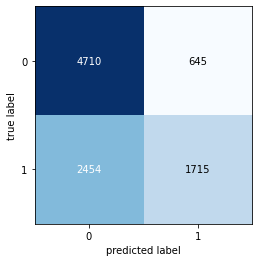

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

divide = [y for x, y in data.groupby('Repacked', as_index=False)]
RP = divide[1]
NotRP = divide[0]

print(RP['StringOffset'].value_counts())
print(NotRP['StringOffset'].value_counts())

binary1 = np.array([[4710, 645],
                    [2454, 1715]])

fig, ax = plot_confusion_matrix(conf_mat=binary1)
plt.show()

In [ ]:
RP.describe()

,BroadcastReceiverOccurenceFrequency,ActivityOccurenceFrequency:,ServicesOccurenceFrequency:,TotalComponentFrequency:,MostCommonTargetComponent:,MostCommonSourceComponent:,InternalOccurence:,ExternalOccurence,Permissions,NormalPerms,DangerousPerms,SignaturePerms,RiskRatePerPerms,androidApiCount,javaApiCount,totalApiCount,apiPerComponent,userActionCount,userActionPerComponent
count,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000
mean,2.986041,38.834450,11.698213,53.518705,12.822585,6.946678,3.475851,50.468035,7.557929,2.985762,3.389587,2.985762,0.432419,15.349386,9.733948,25.083333,inf,12.380095,inf
std,5.716517,39.810783,12.890423,48.695214,11.934576,5.352591,8.569519,44.878734,7.532210,2.610681,3.175751,2.610681,0.187856,13.862070,12.663996,25.404133,NaN,7.929291,NaN
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.124088,1.000000,0.007519
25%,0.000000,13.000000,1.000000,18.000000,4.000000,4.000000,1.000000,17.000000,4.000000,2.000000,2.000000,2.000000,0.333333,7.000000,6.000000,13.000000,0.387097,6.000000,0.200000
50%,1.000000,29.000000,6.000000,47.000000,9.000000,6.000000,1.000000,45.000000,5.000000,2.000000,3.000000,2.000000,0.500000,16.000000,8.000000,24.000000,0.523810,12.000000,0.306452
75%,3.000000,56.000000,29.000000,67.000000,26.000000,8.000000,4.000000,63.000000,9.000000,3.000000,4.000000,3.000000,0.600000,20.000000,12.000000,31.000000,0.829268,19.000000,0.380952
max,93.000000,631.000000,108.000000,698.000000,219.000000,133.000000,309.000000,634.000000,170.000000,42.000000,56.000000,42.000000,1.000000,471.000000,537.000000,1008.000000,inf,72.000000,inf


In [ ]:
NotRP.describe()

,BroadcastReceiverOccurenceFrequency,ActivityOccurenceFrequency:,ServicesOccurenceFrequency:,TotalComponentFrequency:,MostCommonTargetComponent:,MostCommonSourceComponent:,InternalOccurence:,ExternalOccurence,Permissions,NormalPerms,DangerousPerms,SignaturePerms,RiskRatePerPerms,androidApiCount,javaApiCount,totalApiCount,apiPerComponent,userActionCount,userActionPerComponent
count,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.00000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000
mean,2.588559,43.368220,7.466949,53.423729,9.575424,7.002966,4.60000,49.286441,8.033051,3.131780,3.419492,3.131780,0.382942,17.005932,11.442797,28.448729,inf,11.379237,inf
std,5.225946,56.529828,10.068511,63.956920,12.263128,7.390489,15.23119,55.498818,8.667848,2.708223,3.401039,2.708223,0.203024,20.998314,20.886888,39.849600,NaN,9.072446,NaN
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.124088,1.000000,0.025424
25%,0.000000,9.000000,0.000000,12.000000,3.000000,3.000000,1.00000,11.000000,3.000000,2.000000,1.000000,2.000000,0.315789,6.000000,5.000000,12.000000,0.455611,4.000000,0.193909
50%,1.000000,28.000000,3.000000,37.000000,6.000000,6.000000,1.00000,35.000000,6.000000,2.000000,3.000000,2.000000,0.428571,14.000000,8.000000,24.000000,0.651163,10.000000,0.282330
75%,3.000000,59.000000,10.000000,73.000000,11.000000,8.000000,3.00000,69.000000,10.000000,3.000000,5.000000,3.000000,0.500000,21.000000,14.000000,36.000000,1.000000,18.000000,0.428571
max,86.000000,926.000000,64.000000,950.000000,204.000000,142.000000,376.00000,601.000000,165.000000,32.000000,41.000000,32.000000,1.000000,484.000000,480.000000,964.000000,inf,142.000000,inf


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb9dee4550>,
      dtype=object)

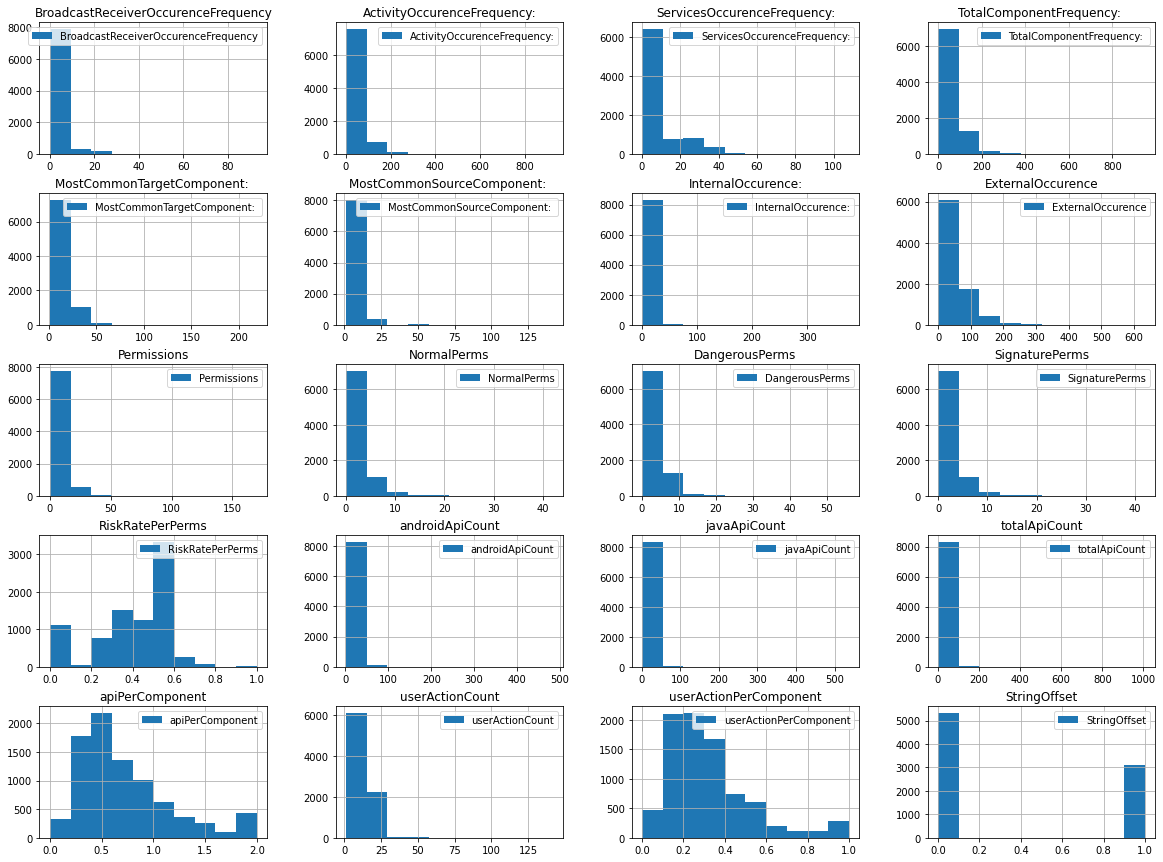

In [ ]:
X.hist(legend=True,figsize=(20,15))

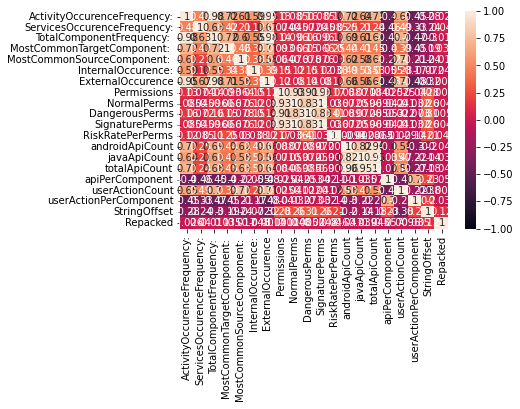

In [ ]:
import seaborn as sns
from sklearn.preprocessing import Normalizer

sc_X = StandardScaler()
scaleddata = dataClean.iloc[:,1:]
scaleddata = scaleddata.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
normalizeddf_train = Normalizer().fit_transform(scaleddata)
scaleddata.corr()
sns.heatmap(scaleddata.corr(), vmin=-1, vmax=1, annot=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use o

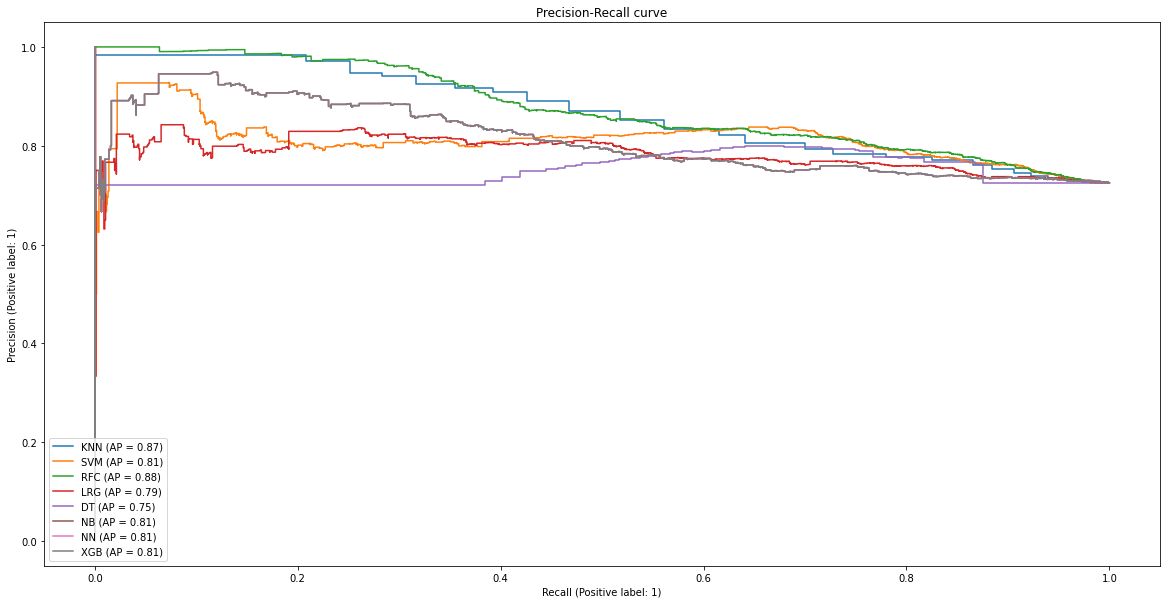

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plot_precision_recall_curve(knn, X_test, y_test, ax = plt.gca(),name = "KNN")

plot_precision_recall_curve(model, X_test, y_test, ax = plt.gca(),name = "SVM")

plot_precision_recall_curve(rfc, X_test, y_test, ax = plt.gca(),name = "RFC")

plot_precision_recall_curve(lrg, X_test, y_test, ax = plt.gca(),name = "LRG")

plot_precision_recall_curve(deetree, X_test, y_test, ax = plt.gca(),name = "DT")

plot_precision_recall_curve(gnb, X_test, y_test, ax = plt.gca(),name = "NB")

plot_precision_recall_curve(gnb, X_test, y_test, ax = plt.gca(),name = "NN")

plot_precision_recall_curve(gnb, X_test, y_test, ax = plt.gca(),name = "XGB")

plt.title('Precision-Recall curve')

plt.show()


In [ ]:
copies = data[(data["BroadcastReceiverOccurenceFrequency"] == 3) & 
              (data["ActivityOccurenceFrequency:"] == 29) &
              (data["ServicesOccurenceFrequency:"] == 30) &
              (data["TotalComponentFrequency: "] == 62) &
              (data["MostCommonTargetComponent: "] == 26) &
              (data["MostCommonSourceComponent: "] == 8) &
              (data["InternalOccurence:"] == 4) &
              (data["ExternalOccurence"] == 58) &
              (data["Permissions"] == 5) &
              (data["NormalPerms"] == 2) &
              (data["DangerousPerms"] == 3) &
              (data["SignaturePerms"] == 2) &
              (data["RiskRatePerPerms"] == 0.6) &
              (data["androidApiCount"] == 16) &
              (data["javaApiCount"] == 8) &
              (data["totalApiCount"] == 24) &
              (data["apiPerComponent"] == 0.3870967742) &
              (data["userActionCount"] == 19) &
              (data["userActionPerComponent"] == 0.3064516129)]
              
copies = data[(data["BroadcastReceiverOccurenceFrequency"] == 3) & 
              (data["ActivityOccurenceFrequency:"] == 29) &
              (data["ServicesOccurenceFrequency:"] == 30) &
              (data["TotalComponentFrequency: "] == 62) &
              (data["MostCommonTargetComponent: "] == 26) &
              (data["MostCommonSourceComponent: "] == 8) &
              (data["InternalOccurence:"] == 4) &
              (data["ExternalOccurence"] == 58)]

#print(copies) #[1083 rows x 22 columns]

data1 = data
data1.drop(data1.index[(data1["BroadcastReceiverOccurenceFrequency"] == 3) & 
                       (data1["ActivityOccurenceFrequency:"] == 29) & 
                       (data1["ServicesOccurenceFrequency:"] == 30) & 
                       (data1["TotalComponentFrequency: "] == 62) & 
                       (data1["MostCommonTargetComponent: "] == 26) & 
                       (data1["MostCommonSourceComponent: "] == 8) & 
                       (data1["InternalOccurence:"] == 4) & 
                       (data1["ExternalOccurence"] == 58)], inplace=True)

(data1.Repacked.values == True).sum()

#print(data1) #[8441 rows x 22 columns]

6081